Errorcheck

In [10]:
import geopandas as gp
import rasterio
from rasterio.features import shapes

import matplotlib.pyplot as plt
import os
import time 
import pandas as pd
def changeErrorCheck(
    change_map,
    gt_source,
    gt_target,
    pred_source,
    pred_target, 
    outdir):

    """
    Base on the error in the change map and confusion matrix, the No Change to Change category is inspected to know the source of error.

    Output: Table 
        gt_source | gt_target | predicted_ source | predicted_target
    Note: Source and Target in the case are 2018 and 2019 respectively
    """

    # read change map
    mask = None
    with rasterio.open(change_map) as src:
        crs_ = src.crs
        img = src.read(1)
        geom_atrri = ({'properties' : {'change_val': v}, 'geometry': s} for i, (s, v) in enumerate(shapes(img, mask=mask, transform=src.transform)))
    ncc_gdf = gp.GeoDataFrame.from_features(geom_atrri, crs=crs_)
    # select the No change to Change category
    ncc_gdf = ncc_gdf[ncc_gdf['change_val'] == 2]
    ncc_gdf['row_ix'] = ncc_gdf.index


    #free img and 
    img = None
    geom_atrri = None

    # read gt_source and gt_target
    gt_source = (gp.read_file(gt_source).to_crs(crs_))

    gt_target = (gp.read_file(gt_target)).to_crs(crs_)

    
    # read pred_source and pred_target
    def polygonize(raster_path, attribute_name):
        """ returns polygon of the input raster"""
        mask = None
        with rasterio.open(raster_path) as src:
            img = src.read(1)
            geom_atrri = ({'properties' : {'%s' % attribute_name: v}, 'geometry': s} for i, (s, v) in enumerate(shapes(img, mask=mask, transform=src.transform)))
        gdf = gp.GeoDataFrame.from_features(geom_atrri, crs=crs_)
        # gdf = gdf.head(2000)
        img = None
        return gdf
    
    pred_source = polygonize(pred_source, 'pred_18')
    pred_target = polygonize(pred_target, 'pred_19')
    
    label = ['Dense built-up area', 'Diffuse built-up area', 'Industrial and commercial areas', 'Roads', 'Oilseeds (Rapeseed)', 'Straw cereals (Wheat, Triticale, Barley)', 'Protein crops (Beans / Peas)', 'Soy', 'Sunflower', 'Corn',  'Tubers/roots', 'Grasslands', 'Orchards and fruit growing', 'Vineyards', 'Hardwood forest', 'Softwood forest', 'Natural grasslands and pastures', 'Woody moorlands', 'Water']
    # spatial join 
    # gt
    gt_source_df = gp.sjoin(ncc_gdf, gt_source, how='inner', predicate='intersects')
    gt_source_df = gt_source_df.rename(columns={'code': 'gt_source'})
    # print('gt_source_df.. \n',gt_source_df.head(2))
    gt_target_df = gp.sjoin(ncc_gdf, gt_target, how='inner', predicate='intersects')
    gt_target_df = gt_target_df.rename(columns={'code': 'gt_target'})
    # print('gt_target_df.. \n',gt_target_df.head(2))

    # pred
    pred_source_df = gp.sjoin(ncc_gdf, pred_source, how='inner', predicate='intersects')
    # print('pred_source.. \n', pred_source_df.head(2))
    pred_target_df = gp.sjoin(ncc_gdf, pred_target, how='inner', predicate='intersects')
    # print(pred_target_df.head(2))

    # join ncc_gdf with gt_source_df['code'], gt_target_df['code'], pred_source_df['pred18'], pred_target_df['pred_19']
    ncc_gdf = ncc_gdf.merge(gt_source_df[['row_ix', 'gt_source']], on='row_ix', how='left')
    ncc_gdf = ncc_gdf.merge(gt_target_df[['row_ix', 'gt_target']], on='row_ix', how='left')
    ncc_gdf = ncc_gdf.merge(pred_source_df[['row_ix', 'pred_18']], on='row_ix', how='left')
    ncc_gdf = ncc_gdf.merge(pred_target_df[['row_ix', 'pred_19']], on='row_ix', how='left')
    
    # new df with source, target, pred18 and pred19
    # gdf_ = ncc_gdf[['row_ix', 'gt_source', 'gt_target', 'pred_18', 'pred_19']]
    gdf_ = ncc_gdf.loc[:, ['row_ix', 'gt_source', 'gt_target', 'pred_18', 'pred_19']]
    
    # rename class to label
    gdf_['pred_18'] = gdf_['pred_18'].map(dict(zip(range(1, len(label) + 1), label)))
    gdf_['pred_19'] = gdf_['pred_19'].map(dict(zip(range(1, len(label) + 1), label)))
    gdf_['gt_source'] = gdf_['gt_source'].map(dict(zip(range(1, len(label) + 1), label)))
    gdf_['gt_target'] = gdf_['gt_target'].map(dict(zip(range(1, len(label) + 1), label)))
    # save the error table
    # ncc_gdf.to_csv(os.path.join(outdir, 'error_table' + output_name +'.csv'))
    # check the error
    err_df = gdf_.groupby(['pred_18', 'pred_19']).size()
    errorstat_df = err_df.to_frame(name= 'count').reset_index()
    errorstat_df.sort_values(by=['count'], ascending=False, inplace=True)
    errorstat_df = errorstat_df[errorstat_df['pred_18'] != errorstat_df['pred_19']]
    # label = ['Dense built-up area', 'Diffuse built-up area', 'Industrial and commercial areas', 'Roads', 'Oilseeds (Rapeseed)', 'Straw cereals (Wheat, Triticale, Barley)', 'Protein crops (Beans / Peas)', 'Soy', 'Sunflower', 'Corn',  'Tubers/roots', 'Grasslands', 'Orchards and fruit growing', 'Vineyards', 'Hardwood forest', 'Softwood forest', 'Natural grasslands and pastures', 'Woody moorlands', 'Water']
    # errorstat_df['pred_18'] = errorstat_df['pred_18'].map(dict(zip(range(1, len(label) + 1), label)))
    # errorstat_df['pred_19'] = errorstat_df['pred_19'].map(dict(zip(range(1, len(label) + 1), label)))
    errorstat_df['change'] = errorstat_df.apply(lambda x: str(x['pred_18']) + ' -> ' + str(x['pred_19']), axis=1)
    
    # output name and dir
    output_name = os.path.basename(change_map).split('.')[-2]
    output_name = output_name.split('_')[-2:]
    output_name = '_'.join(output_name)
    
    # save the error table
    gdf_.to_csv(os.path.join(outdir, 'error_table_' + output_name +'.csv'))
    errorstat_df.to_csv(os.path.join(outdir, 'error_count_' + output_name +'.csv'))
    
    plt.figure(figsize=(35,15))
    errorstat_df = errorstat_df.head(20)
    errorstat_df.plot.bar(x='change', y='count', rot=90)
    plt.title('First 20 class changes error count')
    plt.savefig(os.path.join(outdir, output_name +'.png'), bbox_inches="tight")
    # errorstat_df.to_csv(os.path.join(outdir, output_name +'.csv'))
    # return ncc_gdf
    

In [11]:
change_map = '../../../results/RF/change_D/change_map_case_2.tif'
gt_source = '../../../data/sample_shapefiles/samples_oso2018_T31TCJ.shp'
gt_target = '../../../data/sample_shapefiles/samples_oso2019_T31TCJ.shp'
pred_source = '../../../results/RF/2018_rf_model_2_map.tif'
pred_target = '../../../results/RF/2019_rf_model_2_map.tif'
outdir = '../../../results/RF/change_D/errorstats'

Run time: 19.31919463475545 minutes


<Figure size 2520x1080 with 0 Axes>

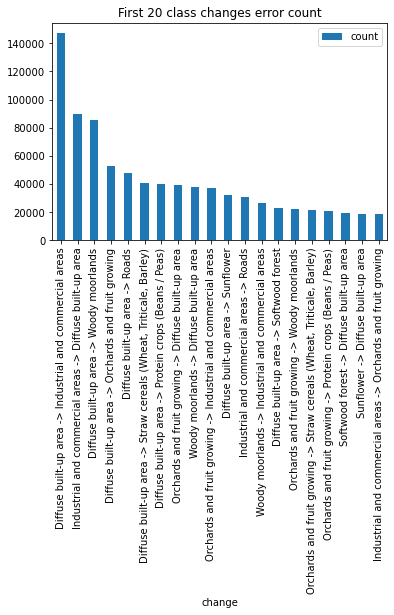

In [12]:
start_time = time.time()
changeErrorCheck(change_map, gt_source, gt_target, pred_source, pred_target, outdir)
print("Run time: %s minutes" % ((time.time() - start_time)/60))

model 1 = Run time: 19.66328562895457 minutes  
model 2 = Run time: 19.55838039716085 minutes

In [38]:
errorstat = important_gdf.groupby(['pred_18', 'pred_19']).size()
errorstat_df = errorstat.to_frame(name= 'count').reset_index()

In [52]:
errorstat_df.sort_values(by=['count'], ascending=False, inplace=True)

In [110]:
# errorstat_df

In [54]:
errorstat_df_with_ur = errorstat_df[errorstat_df['pred_18'] != errorstat_df['pred_19']]

In [55]:
errorstat_df_with_ur

,pred_18,pred_19,count
14,2.0,3.0,147284
32,3.0,2.0,89918
28,2.0,18.0,85780
23,2.0,13.0,52926
15,2.0,4.0,48113
...,...,...,...
266,17.0,12.0,1
183,12.0,7.0,1
60,4.0,12.0,1
238,16.0,1.0,1


In [14]:
import os
import json
save_df = '../../../results/RF/change_D/errorstats'

# errorstat_df.to_csv(os.path.join(save_df, 'errorstat_df.csv'))


In [15]:
# important_gdf.to_file('checkerror_model_2.shp')

In [101]:
import pandas as pd
save_df = '../../../results/RF/change_D/errorstats/errorstat_df.csv'
err_df = pd.read_csv(save_df)

In [102]:
err_df.sort_values(by=['count'], ascending=False, inplace=True)

In [103]:
err_df = err_df[err_df['pred_18'] != err_df['pred_19']]
# err_df.head(50)

In [104]:
err_df

,Unnamed: 0,pred_18,pred_19,count
14,14,2.0,3.0,147284
32,32,3.0,2.0,89918
28,28,2.0,18.0,85780
23,23,2.0,13.0,52926
15,15,2.0,4.0,48113
...,...,...,...,...
266,266,17.0,12.0,1
183,183,12.0,7.0,1
60,60,4.0,12.0,1
238,238,16.0,1.0,1


In [105]:
label = ['Dense built-up area', 'Diffuse built-up area', 'Industrial and commercial areas', 'Roads', 'Oilseeds (Rapeseed)', 'Straw cereals (Wheat, Triticale, Barley)', 'Protein crops (Beans / Peas)', 'Soy', 'Sunflower', 'Corn',  'Tubers/roots', 'Grasslands', 'Orchards and fruit growing', 'Vineyards', 'Hardwood forest', 'Softwood forest', 'Natural grasslands and pastures', 'Woody moorlands', 'Water']
err_df['pred_18'] = err_df['pred_18'].map(dict(zip(range(1, len(label) + 1), label)))
err_df['pred_19'] = err_df['pred_19'].map(dict(zip(range(1, len(label) + 1), label)))

In [106]:
# err_df['transition'] = str(err_df['pred_18']) + '-' + str(err_df['pred_19'])
err_df['transition'] = err_df.apply(lambda x: str(x['pred_18']) + ' -> ' + str(x['pred_19']), axis=1)

In [107]:
err_df.drop('Unnamed: 0', axis=1, inplace=True)
err_df

,pred_18,pred_19,count,transition
14,Diffuse built-up area,Industrial and commercial areas,147284,Diffuse built-up area -> Industrial and commer...
32,Industrial and commercial areas,Diffuse built-up area,89918,Industrial and commercial areas -> Diffuse bui...
28,Diffuse built-up area,Woody moorlands,85780,Diffuse built-up area -> Woody moorlands
23,Diffuse built-up area,Orchards and fruit growing,52926,Diffuse built-up area -> Orchards and fruit gr...
15,Diffuse built-up area,Roads,48113,Diffuse built-up area -> Roads
...,...,...,...,...
266,Natural grasslands and pastures,Grasslands,1,Natural grasslands and pastures -> Grasslands
183,Grasslands,Protein crops (Beans / Peas),1,Grasslands -> Protein crops (Beans / Peas)
60,Roads,Grasslands,1,Roads -> Grasslands
238,Softwood forest,Dense built-up area,1,Softwood forest -> Dense built-up area


<Figure size 3600x2880 with 0 Axes>

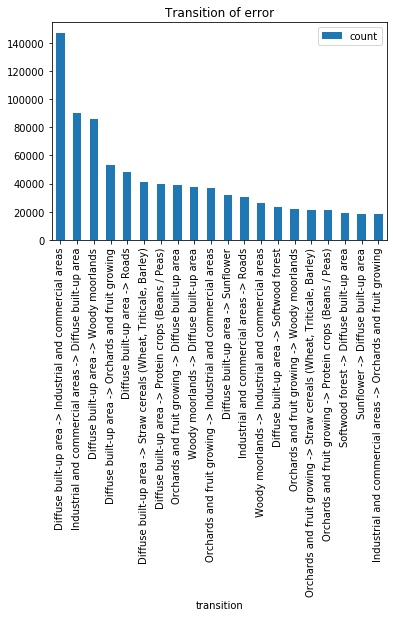

In [111]:
plt.figure(figsize=(50,40))
err_df = err_df.head(20)
err_df.plot.bar(x='transition', y='count', rot=90)
plt.title('Transition of error')
plt.show()